##sliding window view

In [ ]:
import numpy as np
from numpy.core.numeric import normalize_axis_tuple
from numpy.core.overrides import array_function_dispatch, set_module

__all__ = ['broadcast_to', 'broadcast_arrays', 'broadcast_shapes']


class DummyArray:
    """Dummy object that just exists to hang __array_interface__ dictionaries
    and possibly keep alive a reference to a base array.
    """

    def __init__(self, interface, base=None):
        self.__array_interface__ = interface
        self.base = base


def _maybe_view_as_subclass(original_array, new_array):
    if type(original_array) is not type(new_array):
        # if input was an ndarray subclass and subclasses were OK,
        # then view the result as that subclass.
        new_array = new_array.view(type=type(original_array))
        # Since we have done something akin to a view from original_array, we
        # should let the subclass finalize (if it has it implemented, i.e., is
        # not None).
        if new_array.__array_finalize__:
            new_array.__array_finalize__(original_array)
    return new_array


def as_strided(x, shape=None, strides=None, subok=False, writeable=True):
    """
    Create a view into the array with the given shape and strides.
    .. warning:: This function has to be used with extreme care, see notes.
    Parameters
    ----------
    x : ndarray
        Array to create a new.
    shape : sequence of int, optional
        The shape of the new array. Defaults to ``x.shape``.
    strides : sequence of int, optional
        The strides of the new array. Defaults to ``x.strides``.
    subok : bool, optional
        .. versionadded:: 1.10
        If True, subclasses are preserved.
    writeable : bool, optional
        .. versionadded:: 1.12
        If set to False, the returned array will always be readonly.
        Otherwise it will be writable if the original array was. It
        is advisable to set this to False if possible (see Notes).
    Returns
    -------
    view : ndarray
    See also
    --------
    broadcast_to : broadcast an array to a given shape.
    reshape : reshape an array.
    lib.stride_tricks.sliding_window_view :
        userfriendly and safe function for the creation of sliding window views.
    Notes
    -----
    ``as_strided`` creates a view into the array given the exact strides
    and shape. This means it manipulates the internal data structure of
    ndarray and, if done incorrectly, the array elements can point to
    invalid memory and can corrupt results or crash your program.
    It is advisable to always use the original ``x.strides`` when
    calculating new strides to avoid reliance on a contiguous memory
    layout.
    Furthermore, arrays created with this function often contain self
    overlapping memory, so that two elements are identical.
    Vectorized write operations on such arrays will typically be
    unpredictable. They may even give different results for small, large,
    or transposed arrays.
    Since writing to these arrays has to be tested and done with great
    care, you may want to use ``writeable=False`` to avoid accidental write
    operations.
    For these reasons it is advisable to avoid ``as_strided`` when
    possible.
    """
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)
    interface = dict(x.__array_interface__)
    if shape is not None:
        interface['shape'] = tuple(shape)
    if strides is not None:
        interface['strides'] = tuple(strides)

    array = np.asarray(DummyArray(interface, base=x))
    # The route via `__interface__` does not preserve structured
    # dtypes. Since dtype should remain unchanged, we set it explicitly.
    array.dtype = x.dtype

    view = _maybe_view_as_subclass(x, array)

    if view.flags.writeable and not writeable:
        view.flags.writeable = False

    return view


def _sliding_window_view_dispatcher(x, window_shape, axis=None, *,
                                    subok=None, writeable=None):
    return (x,)


@array_function_dispatch(_sliding_window_view_dispatcher)
def sliding_window_view(x, window_shape, axis=None, *,
                        subok=False, writeable=False):
    """
    Create a sliding window view into the array with the given window shape.
    Also known as rolling or moving window, the window slides across all
    dimensions of the array and extracts subsets of the array at all window
    positions.
    
    .. versionadded:: 1.20.0
    Parameters
    ----------
    x : array_like
        Array to create the sliding window view from.
    window_shape : int or tuple of int
        Size of window over each axis that takes part in the sliding window.
        If `axis` is not present, must have same length as the number of input
        array dimensions. Single integers `i` are treated as if they were the
        tuple `(i,)`.
    axis : int or tuple of int, optional
        Axis or axes along which the sliding window is applied.
        By default, the sliding window is applied to all axes and
        `window_shape[i]` will refer to axis `i` of `x`.
        If `axis` is given as a `tuple of int`, `window_shape[i]` will refer to
        the axis `axis[i]` of `x`.
        Single integers `i` are treated as if they were the tuple `(i,)`.
    subok : bool, optional
        If True, sub-classes will be passed-through, otherwise the returned
        array will be forced to be a base-class array (default).
    writeable : bool, optional
        When true, allow writing to the returned view. The default is false,
        as this should be used with caution: the returned view contains the
        same memory location multiple times, so writing to one location will
        cause others to change.
    Returns
    -------
    view : ndarray
        Sliding window view of the array. The sliding window dimensions are
        inserted at the end, and the original dimensions are trimmed as
        required by the size of the sliding window.
        That is, ``view.shape = x_shape_trimmed + window_shape``, where
        ``x_shape_trimmed`` is ``x.shape`` with every entry reduced by one less
        than the corresponding window size.
    See Also
    --------
    lib.stride_tricks.as_strided: A lower-level and less safe routine for
        creating arbitrary views from custom shape and strides.
    broadcast_to: broadcast an array to a given shape.
    Notes
    -----
    For many applications using a sliding window view can be convenient, but
    potentially very slow. Often specialized solutions exist, for example:
    - `scipy.signal.fftconvolve`
    - filtering functions in `scipy.ndimage`
    - moving window functions provided by
      `bottleneck <https://github.com/pydata/bottleneck>`_.
    As a rough estimate, a sliding window approach with an input size of `N`
    and a window size of `W` will scale as `O(N*W)` where frequently a special
    algorithm can achieve `O(N)`. That means that the sliding window variant
    for a window size of 100 can be a 100 times slower than a more specialized
    version.
    Nevertheless, for small window sizes, when no custom algorithm exists, or
    as a prototyping and developing tool, this function can be a good solution.
    Examples
    --------
    >>> x = np.arange(6)
    >>> x.shape
    (6,)
    >>> v = sliding_window_view(x, 3)
    >>> v.shape
    (4, 3)
    >>> v
    array([[0, 1, 2],
           [1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    This also works in more dimensions, e.g.
    >>> i, j = np.ogrid[:3, :4]
    >>> x = 10*i + j
    >>> x.shape
    (3, 4)
    >>> x
    array([[ 0,  1,  2,  3],
           [10, 11, 12, 13],
           [20, 21, 22, 23]])
    >>> shape = (2,2)
    >>> v = sliding_window_view(x, shape)
    >>> v.shape
    (2, 3, 2, 2)
    >>> v
    array([[[[ 0,  1],
             [10, 11]],
            [[ 1,  2],
             [11, 12]],
            [[ 2,  3],
             [12, 13]]],
           [[[10, 11],
             [20, 21]],
            [[11, 12],
             [21, 22]],
            [[12, 13],
             [22, 23]]]])
    The axis can be specified explicitly:
    >>> v = sliding_window_view(x, 3, 0)
    >>> v.shape
    (1, 4, 3)
    >>> v
    array([[[ 0, 10, 20],
            [ 1, 11, 21],
            [ 2, 12, 22],
            [ 3, 13, 23]]])
    The same axis can be used several times. In that case, every use reduces
    the corresponding original dimension:
    >>> v = sliding_window_view(x, (2, 3), (1, 1))
    >>> v.shape
    (3, 1, 2, 3)
    >>> v
    array([[[[ 0,  1,  2],
             [ 1,  2,  3]]],
           [[[10, 11, 12],
             [11, 12, 13]]],
           [[[20, 21, 22],
             [21, 22, 23]]]])
    Combining with stepped slicing (`::step`), this can be used to take sliding
    views which skip elements:
    >>> x = np.arange(7)
    >>> sliding_window_view(x, 5)[:, ::2]
    array([[0, 2, 4],
           [1, 3, 5],
           [2, 4, 6]])
    or views which move by multiple elements
    >>> x = np.arange(7)
    >>> sliding_window_view(x, 3)[::2, :]
    array([[0, 1, 2],
           [2, 3, 4],
           [4, 5, 6]])
    A common application of `sliding_window_view` is the calculation of running
    statistics. The simplest example is the
    `moving average <https://en.wikipedia.org/wiki/Moving_average>`_:
    >>> x = np.arange(6)
    >>> x.shape
    (6,)
    >>> v = sliding_window_view(x, 3)
    >>> v.shape
    (4, 3)
    >>> v
    array([[0, 1, 2],
           [1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> moving_average = v.mean(axis=-1)
    >>> moving_average
    array([1., 2., 3., 4.])
    Note that a sliding window approach is often **not** optimal (see Notes).
    """
    window_shape = (tuple(window_shape)
                    if np.iterable(window_shape)
                    else (window_shape,))
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    window_shape_array = np.array(window_shape)
    if np.any(window_shape_array < 0):
        raise ValueError('`window_shape` cannot contain negative values')

    if axis is None:
        axis = tuple(range(x.ndim))
        if len(window_shape) != len(axis):
            raise ValueError(f'Since axis is `None`, must provide '
                             f'window_shape for all dimensions of `x`; '
                             f'got {len(window_shape)} window_shape elements '
                             f'and `x.ndim` is {x.ndim}.')
    else:
        axis = normalize_axis_tuple(axis, x.ndim, allow_duplicate=True)
        if len(window_shape) != len(axis):
            raise ValueError(f'Must provide matching length window_shape and '
                             f'axis; got {len(window_shape)} window_shape '
                             f'elements and {len(axis)} axes elements.')

    out_strides = x.strides + tuple(x.strides[ax] for ax in axis)

    # note: same axis can be windowed repeatedly
    x_shape_trimmed = list(x.shape)
    for ax, dim in zip(axis, window_shape):
        if x_shape_trimmed[ax] < dim:
            raise ValueError(
                'window shape cannot be larger than input array shape')
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    return as_strided(x, strides=out_strides, shape=out_shape,
                      subok=subok, writeable=writeable)


def _broadcast_to(array, shape, subok, readonly):
    shape = tuple(shape) if np.iterable(shape) else (shape,)
    array = np.array(array, copy=False, subok=subok)
    if not shape and array.shape:
        raise ValueError('cannot broadcast a non-scalar to a scalar array')
    if any(size < 0 for size in shape):
        raise ValueError('all elements of broadcast shape must be non-'
                         'negative')
    extras = []
    it = np.nditer(
        (array,), flags=['multi_index', 'refs_ok', 'zerosize_ok'] + extras,
        op_flags=['readonly'], itershape=shape, order='C')
    with it:
        # never really has writebackifcopy semantics
        broadcast = it.itviews[0]
    result = _maybe_view_as_subclass(array, broadcast)
    # In a future version this will go away
    if not readonly and array.flags._writeable_no_warn:
        result.flags.writeable = True
        result.flags._warn_on_write = True
    return result


def _broadcast_to_dispatcher(array, shape, subok=None):
    return (array,)


@array_function_dispatch(_broadcast_to_dispatcher, module='numpy')
def broadcast_to(array, shape, subok=False):
    """Broadcast an array to a new shape.
    Parameters
    ----------
    array : array_like
        The array to broadcast.
    shape : tuple or int
        The shape of the desired array. A single integer ``i`` is interpreted
        as ``(i,)``.
    subok : bool, optional
        If True, then sub-classes will be passed-through, otherwise
        the returned array will be forced to be a base-class array (default).
    Returns
    -------
    broadcast : array
        A readonly view on the original array with the given shape. It is
        typically not contiguous. Furthermore, more than one element of a
        broadcasted array may refer to a single memory location.
    Raises
    ------
    ValueError
        If the array is not compatible with the new shape according to NumPy's
        broadcasting rules.
    See Also
    --------
    broadcast
    broadcast_arrays
    broadcast_shapes
    Notes
    -----
    .. versionadded:: 1.10.0
    Examples
    --------
    >>> x = np.array([1, 2, 3])
    >>> np.broadcast_to(x, (3, 3))
    array([[1, 2, 3],
           [1, 2, 3],
           [1, 2, 3]])
    """
    return _broadcast_to(array, shape, subok=subok, readonly=True)


def _broadcast_shape(*args):
    """Returns the shape of the arrays that would result from broadcasting the
    supplied arrays against each other.
    """
    # use the old-iterator because np.nditer does not handle size 0 arrays
    # consistently
    b = np.broadcast(*args[:32])
    # unfortunately, it cannot handle 32 or more arguments directly
    for pos in range(32, len(args), 31):
        # ironically, np.broadcast does not properly handle np.broadcast
        # objects (it treats them as scalars)
        # use broadcasting to avoid allocating the full array
        b = broadcast_to(0, b.shape)
        b = np.broadcast(b, *args[pos:(pos + 31)])
    return b.shape


@set_module('numpy')
def broadcast_shapes(*args):
    """
    Broadcast the input shapes into a single shape.
    :ref:`Learn more about broadcasting here <basics.broadcasting>`.
    .. versionadded:: 1.20.0
    Parameters
    ----------
    `*args` : tuples of ints, or ints
        The shapes to be broadcast against each other.
    Returns
    -------
    tuple
        Broadcasted shape.
    Raises
    ------
    ValueError
        If the shapes are not compatible and cannot be broadcast according
        to NumPy's broadcasting rules.
    See Also
    --------
    broadcast
    broadcast_arrays
    broadcast_to
    Examples
    --------
    >>> np.broadcast_shapes((1, 2), (3, 1), (3, 2))
    (3, 2)
    >>> np.broadcast_shapes((6, 7), (5, 6, 1), (7,), (5, 1, 7))
    (5, 6, 7)
    """
    arrays = [np.empty(x, dtype=[]) for x in args]
    return _broadcast_shape(*arrays)


def _broadcast_arrays_dispatcher(*args, subok=None):
    return args


@array_function_dispatch(_broadcast_arrays_dispatcher, module='numpy')
def broadcast_arrays(*args, subok=False):
    """
    Broadcast any number of arrays against each other.
    Parameters
    ----------
    `*args` : array_likes
        The arrays to broadcast.
    subok : bool, optional
        If True, then sub-classes will be passed-through, otherwise
        the returned arrays will be forced to be a base-class array (default).
    Returns
    -------
    broadcasted : list of arrays
        These arrays are views on the original arrays.  They are typically
        not contiguous.  Furthermore, more than one element of a
        broadcasted array may refer to a single memory location. If you need
        to write to the arrays, make copies first. While you can set the
        ``writable`` flag True, writing to a single output value may end up
        changing more than one location in the output array.
        .. deprecated:: 1.17
            The output is currently marked so that if written to, a deprecation
            warning will be emitted. A future version will set the
            ``writable`` flag False so writing to it will raise an error.
    See Also
    --------
    broadcast
    broadcast_to
    broadcast_shapes
    Examples
    --------
    >>> x = np.array([[1,2,3]])
    >>> y = np.array([[4],[5]])
    >>> np.broadcast_arrays(x, y)
    [array([[1, 2, 3],
           [1, 2, 3]]), array([[4, 4, 4],
           [5, 5, 5]])]
    Here is a useful idiom for getting contiguous copies instead of
    non-contiguous views.
    >>> [np.array(a) for a in np.broadcast_arrays(x, y)]
    [array([[1, 2, 3],
           [1, 2, 3]]), array([[4, 4, 4],
           [5, 5, 5]])]
    """
    # nditer is not used here to avoid the limit of 32 arrays.
    # Otherwise, something like the following one-liner would suffice:
    # return np.nditer(args, flags=['multi_index', 'zerosize_ok'],
    #                  order='C').itviews

    args = [np.array(_m, copy=False, subok=subok) for _m in args]

    shape = _broadcast_shape(*args)

    if all(array.shape == shape for array in args):
        # Common case where nothing needs to be broadcasted.
        return args

    return [_broadcast_to(array, shape, subok=subok, readonly=False)
            for array in args]

Hecho por:
##Edward Andres Sandoval Pineda

##Sebastian Perez Lopez

##Sebastian Florez Rojas

#Preparando Notebook

In [ ]:
#@title Importando librerias
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from numpy import load

In [ ]:
#@title Montando Drive
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/Semestre 8/IA-2/Proyecto IA')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/Semestre 8/IA-2/Proyecto IA


In [ ]:
#@title Montando Drive
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/Proyecto IA')
print(os.getcwd())

#Desarrollo

In [ ]:
def e_r_m(y_true,y_predict):
  e_abs = y_true-y_predict
  e_r = np.abs(e_abs/y_true)*100
  return e_r.mean()

def mae(y_true,y_pred):
  return np.abs(y_true-y_pred).mean()

def mse(y_true,y_pred):
  val = (y_true-y_pred)*(y_true-y_pred)
  return val.mean()

In [ ]:
path1='./Datasets/Train/'
path2='./Datasets/Test/'
markets = ["FB","AMZN","NFLX","AAPL","MSFT","GOOGL","TWTR","UBER","NVDA","BABA"] 


li1 = []
li2 = []

for market in markets:
    df1 = pd.read_csv(path1 + market +".csv", index_col=None, header=0)
    df1["Symbol"] = market

    df2 = pd.read_csv(path2 + market +".csv", index_col=None, header=0)
    df2["Symbol"] = market

    li1.append(df1)
    li2.append(df2)

cols = ['open', 'high', 'low', 'close',
       'Volatility', 'Displacement', 'open_std_sc', 'high_std_sc',
       'low_std_sc', 'close_std_sc', 'volume_std_sc', 'Volatility_std_sc',
       'Displacement_std_sc', 'open_MinMax_sc', 'high_MinMax_sc',
       'low_MinMax_sc', 'close_MinMax_sc', 'volume_MinMax_sc',
       'Volatility_MinMax_sc', 'Displacement_MinMax_sc']
      
cols1 = ['open', 'high', 'low', 'close',
       'Volatility', 'Displacement', 'open_std_sc', 'high_std_sc',
       'low_std_sc', 'close_std_sc', 'volume_std_sc', 'Volatility_std_sc',
       'Displacement_std_sc']

window_size = 30
feature_size = 20

##Parte CNN

In [ ]:
def create_model_CNN(window_size,feature_size):
  model_CNN =  tf.keras.models.Sequential()
  model_CNN.add(tf.keras.layers.Conv2D(32, (3, 1), activation='relu', padding='valid', input_shape=(window_size, feature_size,1))),
  model_CNN.add(tf.keras.layers.Dropout(0.1)),
  model_CNN.add(tf.keras.layers.BatchNormalization()),
  model_CNN.add(tf.keras.layers.MaxPooling2D((2, 1))),
  model_CNN.add(tf.keras.layers.Conv2D(64, (3, 1), activation='relu', padding='valid')),
  model_CNN.add(tf.keras.layers.Dropout(0.15)),
  model_CNN.add(tf.keras.layers.BatchNormalization()),
  model_CNN.add(tf.keras.layers.MaxPooling2D((2, 1))),
  model_CNN.add(tf.keras.layers.Conv2D(128, (3, 1), activation='relu', padding='valid')),
  model_CNN.add(tf.keras.layers.Dropout(0.20)),
  model_CNN.add(tf.keras.layers.BatchNormalization()),
  model_CNN.add(tf.keras.layers.MaxPooling2D((2, 1))),
  model_CNN.add(tf.keras.layers.MaxPooling2D((2, 1))),
  model_CNN.add(tf.keras.layers.Conv2D(256, (1, feature_size), activation='relu', padding='valid')),
  model_CNN.add(tf.keras.layers.Dropout(0.25)),
  model_CNN.add(tf.keras.layers.BatchNormalization()),
  model_CNN.add(tf.keras.layers.Conv2D(512, (1, 1), activation='relu', padding='valid')),
  model_CNN.add(tf.keras.layers.Dropout(0.3)),
  model_CNN.add(tf.keras.layers.BatchNormalization()),
  model_CNN.add(tf.keras.layers.Conv2D(1024, (1, 1), activation='relu', padding='valid')),
  model_CNN.add(tf.keras.layers.Dropout(0.3)),
  model_CNN.add(tf.keras.layers.BatchNormalization()),

#Padding valid quita el padding

  model_CNN.add(tf.keras.layers.Flatten())
  model_CNN.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')),
  model_CNN.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform')),
  model_CNN.add(tf.keras.layers.Dense(1, activation='relu'))
  return model_CNN

In [ ]:
mod = create_model_CNN(window_size,feature_size)
mod.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 28, 20, 32)        128       
                                                                 
 dropout_60 (Dropout)        (None, 28, 20, 32)        0         
                                                                 
 batch_normalization_60 (Bat  (None, 28, 20, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 14, 20, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 12, 20, 64)        6208      
                                                                 
 dropout_61 (Dropout)        (None, 12, 20, 64)      

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

eps = 10
modelsCNN_array = []

for i in range(0,len(li1)):
  

  df_train = li1[i][cols].copy()
  df_train.fillna(method="ffill",inplace=True) #Hay veces que hay nulos, entonces se añaden
  X_train = np.squeeze(sliding_window_view(df_train.values,(window_size,feature_size)),axis=1)[:-1]
  y_train =y_train = li1[i]["high"].values[window_size:]

  arr = df_train.iloc[:,:4].values.reshape(-1,1)
  cantidad, valor = np.histogram(arr,bins=100)
  cval = valor[98]-valor[1]


  model_CNN = create_model_CNN(window_size,feature_size)
  opt = tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.9,clipvalue=cval)
  model_CNN.compile(optimizer=opt,loss="mse",metrics=["mse","mae"])
  history = model_CNN.fit(X_train, y_train, epochs=eps, batch_size=32,  validation_split = 0.1)

  modelsCNN_array.append(model_CNN)
  model_CNN.save("modelCNN_"+str(markets[i])+"_"+str(eps)+"epochs.h5")
  print("EMPRESA : "+str(i+1)+" TERMINADA Y GUARDADA")

Epoch 1/10
360/360 [==============================] - 73s 192ms/step - loss: 10583.6289 - mse: 10583.6289 - mae: 55.2780 - val_loss: 531.8020 - val_mse: 531.8020 - val_mae: 22.0763
Epoch 2/10
360/360 [==============================] - 69s 192ms/step - loss: 393.6660 - mse: 393.6660 - mae: 15.8015 - val_loss: 171.9160 - val_mse: 171.9160 - val_mae: 11.5043
Epoch 3/10
360/360 [==============================] - 66s 183ms/step - loss: 306.0025 - mse: 306.0025 - mae: 14.0358 - val_loss: 479.6871 - val_mse: 479.6871 - val_mae: 20.4781
Epoch 4/10
360/360 [==============================] - 66s 182ms/step - loss: 241.6755 - mse: 241.6755 - mae: 12.3983 - val_loss: 124.5675 - val_mse: 124.5675 - val_mae: 10.4319
Epoch 5/10
360/360 [==============================] - 66s 183ms/step - loss: 201.8934 - mse: 201.8934 - mae: 11.3303 - val_loss: 335.3367 - val_mse: 335.3367 - val_mae: 16.6855
Epoch 6/10
360/360 [==============================] - 67s 186ms/step - loss: 144.6892 - mse: 144.6892 - mae: 9.

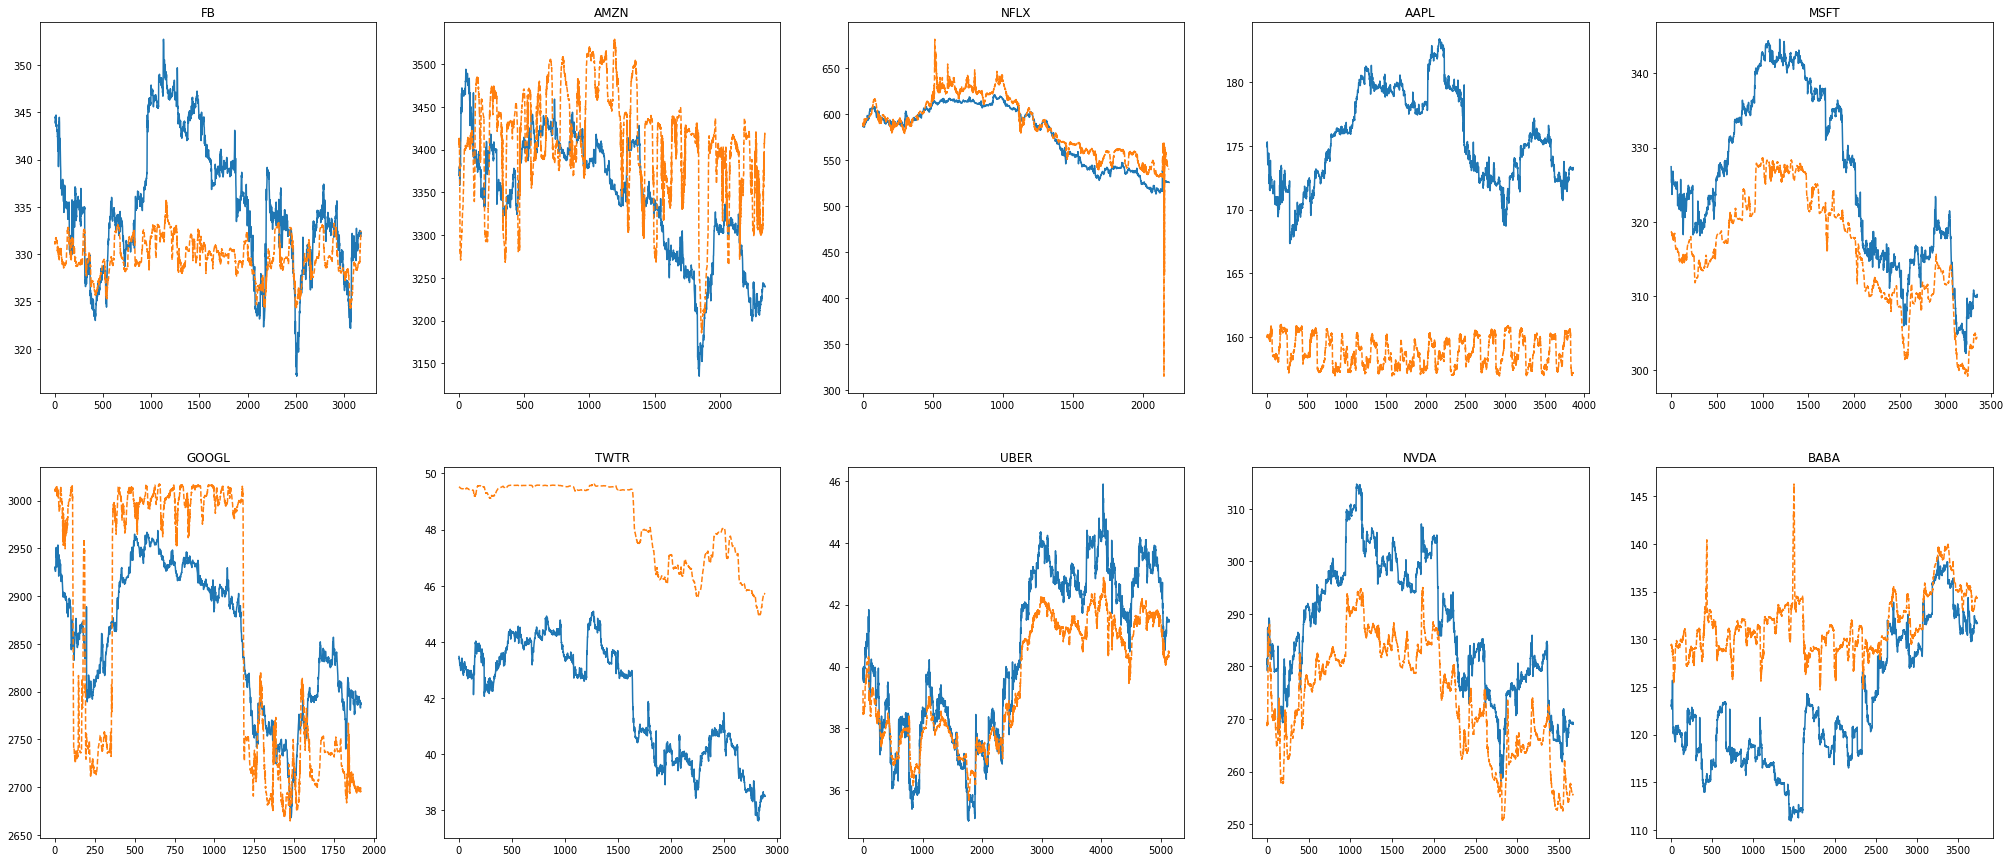

In [ ]:
rel_errs1 = []
maes1 = []
mses1 = []
fig, ax = plt.subplots(nrows=2, ncols=5,figsize=(35,15))

i = 0
for row in ax:
    for col in row:      
        X_test1 = np.squeeze(sliding_window_view(li2[i][cols].values[:,:],(window_size,feature_size)),axis=1)[:-1]
        y_test = li2[i]["high"].values[window_size:]
        y_predict = modelsCNN_array[i].predict(X_test1)
        rel_errs1.append(e_r_m(y_test,y_predict))
        maes1.append(mae(y_test,y_predict))
        mses1.append(mse(y_test,y_predict))
        col.plot(y_test, "-", label="Real")
        col.plot(y_predict, "--", label="Prediccion")
        col.set_title(markets[i])

        i = i+1

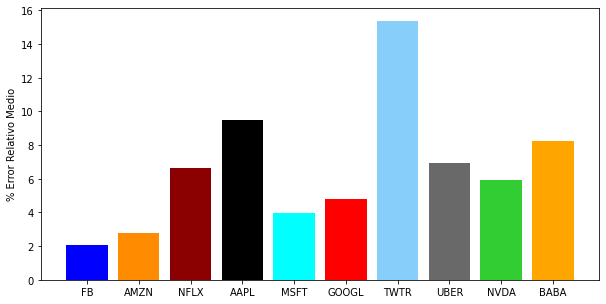

In [ ]:
height = rel_errs1
bars = markets

c = ['blue', 'darkorange', 'darkred', 'black', 'aqua', 'red','lightskyblue','dimgrey','limegreen','orange']
y_pos = np.arange(len(bars))
plt.figure(figsize=(10,5))
plt.bar(y_pos, height,color=c)
plt.xticks(y_pos, bars)
plt.ylabel("% Error Relativo Medio")
plt.show()

{'FB': 7.043, 'AMZN': 91.808, 'NFLX': 37.709, 'AAPL': 16.693, 'MSFT': 13.17, 'GOOGL': 136.884, 'TWTR': 6.343, 'UBER': 2.827, 'NVDA': 17.382, 'BABA': 9.827}


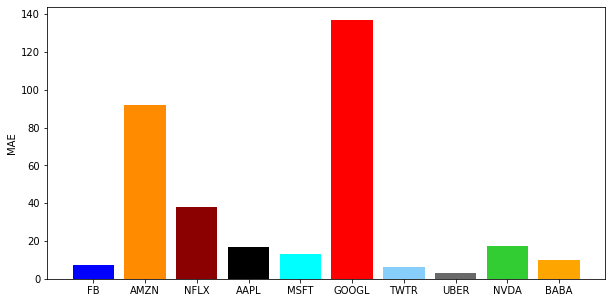

In [ ]:
height = maes1
bars = markets
print({markets[i]:round(maes1[i],3) for i in range(len(maes1))})
c = ['blue', 'darkorange', 'darkred', 'black', 'aqua', 'red','lightskyblue','dimgrey','limegreen','orange']
y_pos = np.arange(len(bars))
plt.figure(figsize=(10,5))
plt.bar(y_pos, height,color=c)
plt.xticks(y_pos, bars)
plt.ylabel("MAE")
plt.show()

{'FB': 79.574, 'AMZN': 13302.383, 'NFLX': 2183.554, 'AAPL': 293.378, 'MSFT': 265.747, 'GOOGL': 24164.693, 'TWTR': 46.374, 'UBER': 11.648, 'NVDA': 456.589, 'BABA': 131.535}


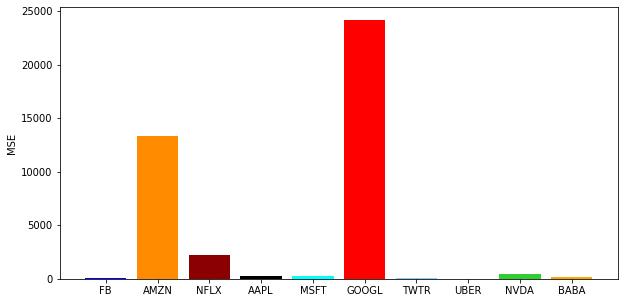

[79.5739638731528, 13302.38333678467, 2183.5538812848954, 293.3783851344503, 265.7473400027142, 24164.693403229296, 46.37388681774076, 11.647513924333781, 456.5892691390997, 131.53534002395537]


In [ ]:
height = mses1
bars = markets
print({markets[i]:round(mses1[i],3) for i in range(len(mses1))})
c = ['blue', 'darkorange', 'darkred', 'black', 'aqua', 'red','lightskyblue','dimgrey','limegreen','orange']
y_pos = np.arange(len(bars))
plt.figure(figsize=(10,5))
plt.bar(y_pos, height,color=c)
plt.xticks(y_pos, bars)
plt.ylabel("MSE")
plt.show()
print(mses1)

##Parte RNN

###Procesando data

Ahora se va a crear el generador de datos

In [ ]:
def windowed_dataset(series, window_size=20, batch_size=32, shuffle_buffer=1000):
    # convert the series to tensor format
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # create the windows shifted 1 position, 
    #drop_remainder keeps the number of elements in the window the same size.
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # convert each window to numpy vector format
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # choose t --> t-1 as a features and the last one as a label
    # [0, 1, 2, 3][4]
    #Se convierte al formato [0, 1, 2, 3][4]
    #dataset = dataset.map(lambda window: (tf.reshape(window[:-1,:],[-1]), window[-1,1]))# La ventana en cada fila tiene un dia y en cada columna una caracteristica
    dataset = dataset.map(lambda window: (window[:-1,:], window[-1,1]))
    # shuffle the data
    dataset = dataset.shuffle(shuffle_buffer)##################################
    # Generate the batches
    # x = [[0, 1, 2, 3], [4, 5, 6, 7]]
    # y = [[4], [8]]
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
window_size = 30
feature_size = 20
#dataset_train = windowed_dataset(df_train.values,window_size)

###Creando y entrenando RNN

In [ ]:
#@title Funcion create_model(window_size,feature_size):
def create_model(window_size,feature_size):
  lambda_input = tf.keras.layers.Lambda(lambda x: tf.reshape(x, (-1,window_size,feature_size)), name='InputTransform')

  simpleRNN1 = tf.keras.layers.SimpleRNN(units=32,
                                       return_sequences=True,
                                       activation=tf.keras.activations.relu,
                                       recurrent_dropout=0.3,
                                       name='RNN_layer1')


  simpleRNN2 = tf.keras.layers.SimpleRNN(units=16,
                                       return_sequences=False,
                                       activation=tf.keras.activations.relu,
                                       recurrent_dropout=0.2,
                                       name='RNN_layer2')


# To calculate the output value

  lambda_output = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=0), name='OutputTransofrm')
# To calculate the output value
  dense1 = tf.keras.layers.Dense(units=32,
                              activation=tf.keras.activations.linear,
                              name='adapt1')

  dense3 = tf.keras.layers.Dense(units=8,
                              activation=tf.keras.activations.linear,
                              name='adapt3')

  dense4 = tf.keras.layers.Dense(units=1,
                              activation=tf.keras.activations.linear,
                              name='regresor')

############################################################################
# Create the model
  input_ = tf.keras.layers.Input(shape=(window_size,feature_size)) #Windowsize * numero de caracteristicas
#aplana = aplanar(input_)
  input_transform = lambda_input(input_)
  x = simpleRNN1(input_transform)
  x = simpleRNN2(x)
  x = dense1(x)
  x = dense3(x)
  y = dense4(x)
############################################################################

  model = tf.keras.Model(inputs=input_, outputs=y)
  return model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

models_array = []
history_array = []
eps = 20
for i in range(0,len(li1)):
  
  df_train = li1[i][cols].copy()
  #df_train = li1[i]["high"].copy()
  df_train.fillna(method="ffill",inplace=True) #Hay veces que hay nulos, entonces se añaden
  dataset_train = windowed_dataset(df_train.values,window_size)
  arr = df_train.iloc[:,:4].values.reshape(-1,1)
  cantidad, valor = np.histogram(arr,bins=100)
  cval = valor[98]-valor[1]

  model = create_model(window_size,feature_size) # Se crea el modelo
  opt = tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.9,clipvalue=cval)
  model.compile(loss="mse", metrics=['mse', 'mae'], optimizer=opt )
  history = model.fit(dataset_train,epochs=eps,verbose=1)
  #model.save("model_"+str(markets[i])+"_"+str(eps)+"epochs.h5")

  print("EMPRESA : "+str(i+1)+" TERMINADA Y GUARDADA")
  models_array.append(model)
  history_array.append(history)

Epoch 1/20
401/401 [==============================] - 11s 22ms/step - loss: 2711.4619 - mse: 2711.4619 - mae: 24.5214
Epoch 2/20
401/401 [==============================] - 8s 21ms/step - loss: 22.5144 - mse: 22.5144 - mae: 3.6895
Epoch 3/20
401/401 [==============================] - 13s 33ms/step - loss: 10.2459 - mse: 10.2459 - mae: 2.6879
Epoch 4/20
401/401 [==============================] - 13s 32ms/step - loss: 9.5648 - mse: 9.5648 - mae: 2.6927
Epoch 5/20
401/401 [==============================] - 8s 20ms/step - loss: 8.8803 - mse: 8.8803 - mae: 2.6374
Epoch 6/20
401/401 [==============================] - 8s 20ms/step - loss: 8.2813 - mse: 8.2813 - mae: 2.5753
Epoch 7/20
401/401 [==============================] - 9s 21ms/step - loss: 7.9270 - mse: 7.9270 - mae: 2.5643
Epoch 8/20
401/401 [==============================] - 13s 33ms/step - loss: 7.7528 - mse: 7.7528 - mae: 2.5413
Epoch 9/20
401/401 [==============================] - 13s 33ms/step - loss: 4.6243 - mse: 4.6243 - mae: 1

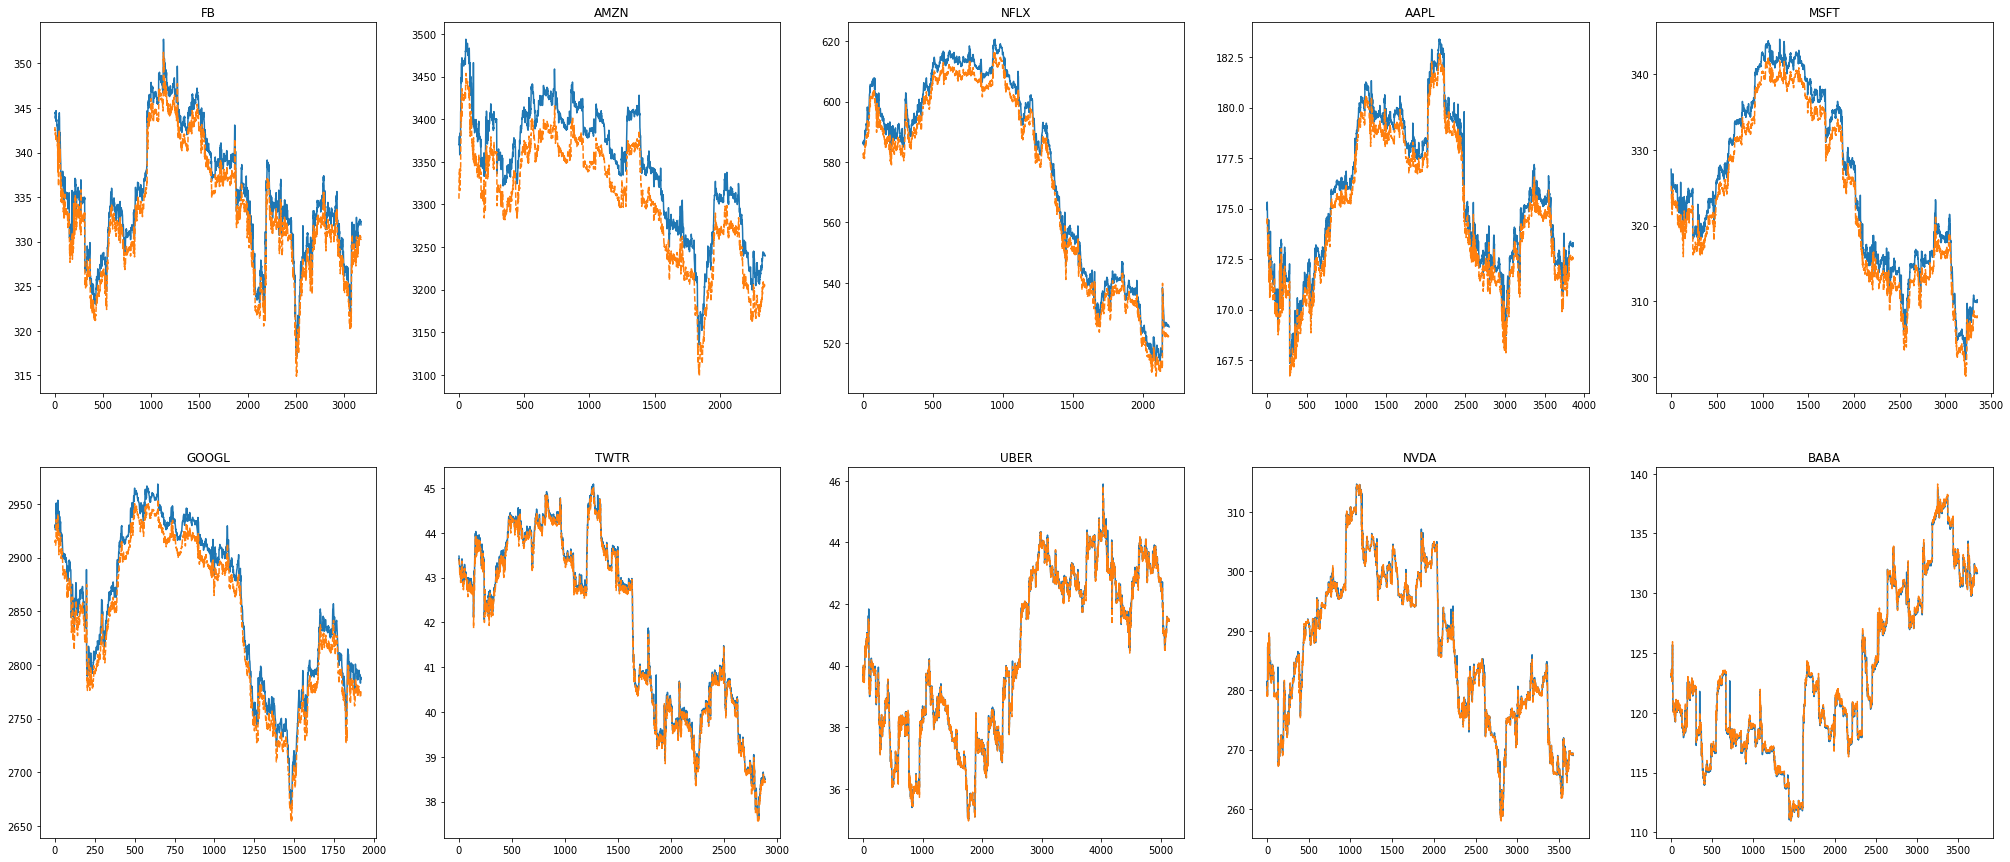

In [ ]:
rel_errs = []
maes = []
mses = []
fig, ax = plt.subplots(nrows=2, ncols=5,figsize=(35,15))

i = 0
for row in ax:
    for col in row:      
        X_test1 = np.squeeze(sliding_window_view(li2[i][cols].values[:,:],(window_size,feature_size)),axis=1)[:-1]
        y_test = li2[i]["high"].values[window_size:]
        y_predict = models_array[i].predict(X_test1)
        rel_errs.append(e_r_m(y_test,y_predict))
        maes.append(mae(y_test,y_predict))
        mses.append(mse(y_test,y_predict))
        col.plot(y_test, "-", label="Real")
        col.plot(y_predict, "--", label="Prediccion")
        col.set_title(markets[i])

        i = i+1

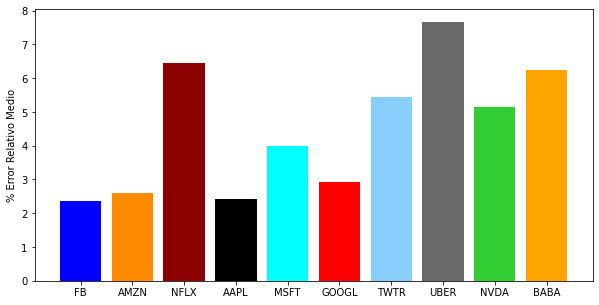

In [ ]:
height = rel_errs
bars = markets
c = ['blue', 'darkorange', 'darkred', 'black', 'aqua', 'red','lightskyblue','dimgrey','limegreen','orange']
y_pos = np.arange(len(bars))
plt.figure(figsize=(10,5))
plt.bar(y_pos, height,color=c)
plt.xticks(y_pos, bars)
plt.ylabel("% Error Relativo Medio")
plt.show()

{'FB': 7.898, 'AMZN': 87.077, 'NFLX': 36.858, 'AAPL': 4.248, 'MSFT': 13.065, 'GOOGL': 83.569, 'TWTR': 2.269, 'UBER': 3.068, 'NVDA': 14.778, 'BABA': 7.728}


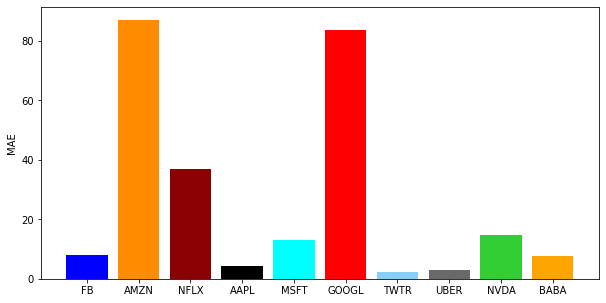

In [ ]:
height = maes
bars = markets
print({markets[i]:round(maes[i],3) for i in range(len(maes))})
c = ['blue', 'darkorange', 'darkred', 'black', 'aqua', 'red','lightskyblue','dimgrey','limegreen','orange']
y_pos = np.arange(len(bars))
plt.figure(figsize=(10,5))
plt.bar(y_pos, height,color=c)
plt.xticks(y_pos, bars)
plt.ylabel("MAE")
plt.show()

{'FB': 96.844, 'AMZN': 11759.632, 'NFLX': 2173.886, 'AAPL': 27.409, 'MSFT': 257.941, 'GOOGL': 10654.19, 'TWTR': 8.014, 'UBER': 14.415, 'NVDA': 330.988, 'BABA': 94.541}


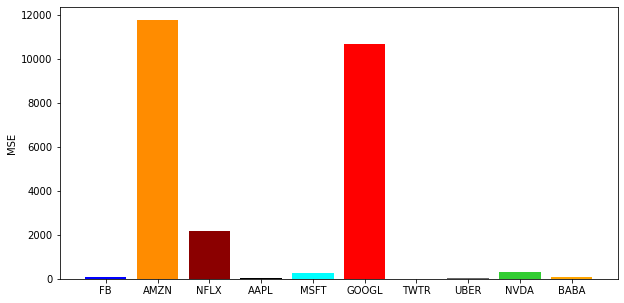

[79.5739638731528, 13302.38333678467, 2183.5538812848954, 293.3783851344503, 265.7473400027142, 24164.693403229296, 46.37388681774076, 11.647513924333781, 456.5892691390997, 131.53534002395537]


In [ ]:
height = mses
bars = markets
print({markets[i]:round(mses[i],3) for i in range(len(mses))})
c = ['blue', 'darkorange', 'darkred', 'black', 'aqua', 'red','lightskyblue','dimgrey','limegreen','orange']
y_pos = np.arange(len(bars))
plt.figure(figsize=(10,5))
plt.bar(y_pos, height,color=c)
plt.xticks(y_pos, bars)
plt.ylabel("MSE")
plt.show()
print(mses1)